In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60
%matplotlib inline
from ivanocode.ivanocommon import *
import pandas as pd

Autosaving every 60 seconds


In [2]:
df_sales_train_melt = pd.read_feather('df_sales_train_melt.feather')

In [3]:
df_sales_train_melt.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,daily_avg_count,monthly_avg_count,day_date,day_date_str,month_id,month,year,date,wm_yr_wk,sell_price,sell_price_flip_count
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.313643,9.409305,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0.257710,7.731312,2011-01-29,2011-01-29,1,1,2011,2011-01-29,11101,NaN,1


In [4]:
df_sales_train_melt['id'].nunique()

30490

In [5]:
sample_ids = df_sales_train_melt['id'].unique()[0:100]

In [6]:
df_sample = df_sales_train_melt.query('id in @sample_ids')

In [7]:
# needed for the feather
df_sample.reset_index(drop=True, inplace=True)

In [8]:
df_sample.to_feather('df_sales_train_melt_sample100series.feather')

In [9]:
len(df_sample)

191300

In [10]:
from fastai.tabular import *

In [11]:
day_ids = list(sorted(df_sample['day_id'].unique()))
len(day_ids)

1913

In [12]:
valid_idx = np.flatnonzero(df_sample['day_id'] > 1800)

In [56]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'sales'
cat_names = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month_id', 'id']
# TODO: see what else other than SNAP's and holidays is missing from the original data
cols = cat_names + ['sell_price'] + [dep_var]

In [57]:
path ='./tmp'
# TODO: check how dates with no sales are represented
data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                procs=procs, cat_names=cat_names)

In [58]:
learn = tabular_learner(data, layers=[200,100], emb_szs=None, metrics=accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


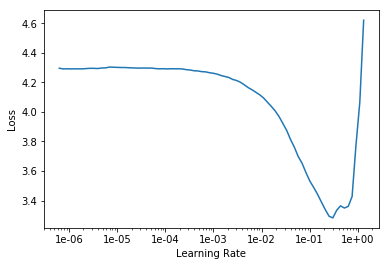

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(3, 2e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.246186,1.456216,0.378386,06:00
1,1.092239,1.286862,0.597097,06:03
2,0.989910,1.187002,0.598070,06:01


In [61]:
# 8865760240
# df_sales_train_melt.values.nbytes

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


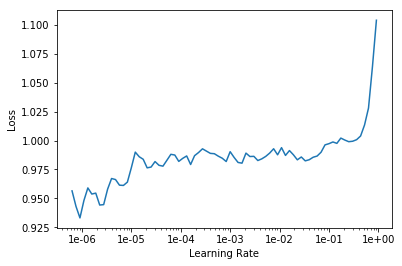

In [62]:
learn.lr_find()
learn.recorder.plot()

In [63]:
list(sorted(df_sales_train_melt['day_date'].unique()))[:1]

[numpy.datetime64('2011-01-29T00:00:00.000000000')]

In [51]:
df_sample_submission = pd.read_csv('raw/sample_submission.csv')
df_sample_submission.head()
from datetime import timedelta
d_1_date = pd.to_datetime('2011-02-08')
mapping = {f'F{day}':(d_1_date + timedelta(days=day-1)).date() for day in range(1,29)}
mapping['id'] = 'id'
# TODO: sell_price should come from last sales day
df_sample_submission.columns = df_sample_submission.columns.map(mapping)
df_sample_submission_melt = df_sample_submission.melt(id_vars='id', var_name='day', value_name='sales')
df_sample_submission_melt.head(1)

,id,day,sales
0,HOBBIES_1_001_CA_1_validation,2011-02-08,0


In [64]:
data = TabularDataBunch.from_df(path, df_sample[cols], dep_var, valid_idx=valid_idx,
                                procs=procs, cat_names=cat_names, test_df=df_sample_submission_melt)